# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Downloading and unzipping the data
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# http://pytorch.org/
# Installing torch for Google Colab
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5858a000 @  0x7f4b5237b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Installing Pillow
!pip uninstall -y Pillow
!pip install Pillow==5.3.0


Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import os
import copy
import PIL
import json
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models

In [0]:
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
# Attaching to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# file path
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

# Constants

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 64

mean = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]

In [0]:
# Defining transforms for the training and validation sets
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,
                                                          std_dev)]),
                  'valid': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,
                                                          std_dev)]) }


# Loading the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train', 'valid']}


# Defining the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                             shuffle = True, num_workers = num_workers)
                for x in ['train', 'valid']}


# Defining the dataset_sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
flower_label_list = None

with open('cat_to_name.json', 'r') as f:
    flower_label_list = json.load(f)

<b>Visualize Data</b>

In [0]:
def plot_img(image, plt):
    '''
    This function plots the image
    '''
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = (image)[:3,:,:].unsqueeze(0)
    
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    plt.imshow(image)
    
def show_images(images, labels):
  '''
  This functions iterates over the images and calls plot_img() function to plot image one by one
  '''
  fig = plt.figure(figsize=(20,5))
  
  for i in np.arange(20):
      x = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
      plot_img(images[i], x)
      idx = str(labels[i].item())
      x.set_title(flower_label_list[idx])


tensor([ 37,  13,  97,  12,  33,  11,  23,  73,   8,  39,  85,  84,  90,  82,
         64,  40,  68,  52,  76,  95,  61,  43,  81,  38,  68,  44,  95,  77,
         95,  15,  88,  65,  98,  98,   5,  77,  75,   8,  75,  49,  85,  75,
         31,  96,   5,   8,  48,  57,  38,  56,  79,  38, 101,  73,  67,  96,
         21,  34,  78,  73,  66,  41,  19,  90])


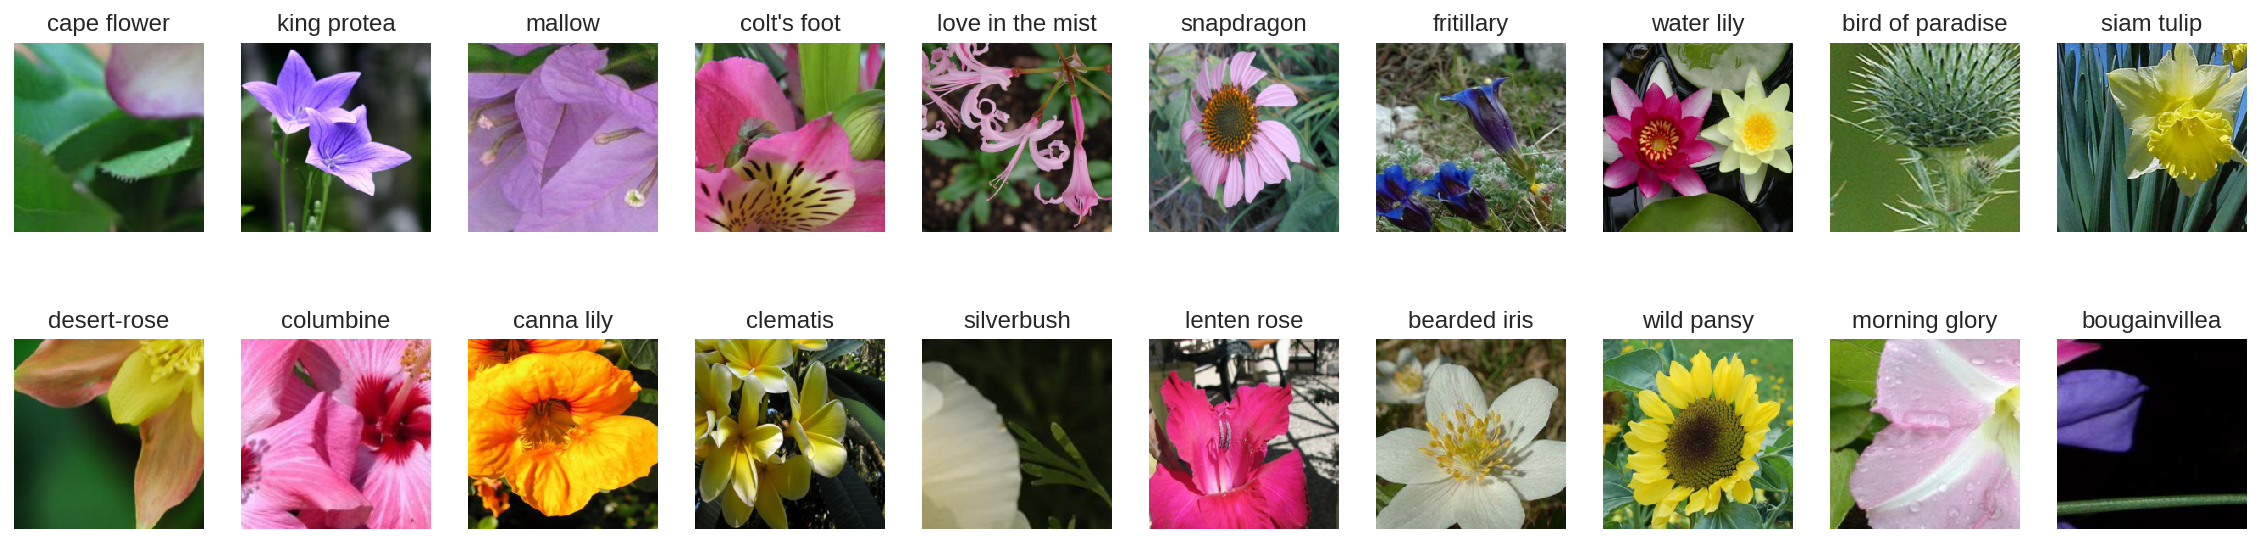

In [0]:
# obtain a batch of images from training dataset
data = iter(dataloaders['train'])

images, labels = data.next()
print(labels)

# call show_images() function to visualize a set of data
show_images(images, labels)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# Building the network
# Training the network

# Loading a pre-trained network
model = models.densenet161(pretrained=True)

# Freezing the parameters
for param in model.parameters():
    param.requires_grad = False
    
# Defining the model using ReLU activations and Dropout
classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(2208, 1024)),
                                ('relu1', nn.ReLU()),
                                ('dropout', nn.Dropout(0.2)),
                                ('fc2', nn.Linear(1024, 102)),
                                #('relu2', nn.ReLU()),
                                #('dropout', nn.Dropout(0.2)),
                                #('fc3', nn.Linear(500, 102)),
                                ('output', nn.LogSoftmax(dim=1))
                                ]))

# Assigning to fully connected layer
model.classifier = classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer 
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001)

# Decay lr by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Checking whether GPU is available
train_on_gpu = torch.cuda.is_available()

if not IOT BASED HUMIDITY AND TEMPERATURE MONITORING USING ARDUINO UNO
 IOT BASED HUMIDITY AND TEMPERATURE MONITORING USING ARDUINO UNO
IoT Based Humidity and Temperature Monitoring Using Arduino Uno:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

# Move model to 'GPU' if available
model.to(device)

CUDA is available!  Training on GPU ...


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_of_epochs=25):

  '''
  Function to train the model
  '''
  
  checkpoint_model_name = 'model_skr_fc_1024.pt'
  checkpoint_model = copy.deepcopy(model.state_dict())
  
  previous_time = time.time()

  # Tracker for best accuracy
  best_acc = 0.0
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  
  # for loop for epochs
  for epoch in range(num_of_epochs):
            
      print('\nIteration: ',epoch+1)
     
      
      # for loop for different phases
      for phase in ['train', 'valid']:
        
          # setting model to train() or eval() mode
          if phase == 'train':
            scheduler.step()
            model.train()
          else:
            model.eval()
            
          # tracker for loss and accuracy          
          phase_loss = 0.0
          phase_acc = 0.0

          # for loop for iterating over data
          for data, labels in dataloaders[phase]:
              
              # moving data, labels to cuda, if it's available
              data, labels = data.to(device), labels.to(device)

              # apply zero gradients
              optimizer.zero_grad()

              # forward - tracking history only for train phase
              with torch.set_grad_enabled(phase == 'train'):
                
                output = model(data)
                _, preds = torch.max(output, 1)
                #preds.to(device)            

                # calculate the loss
                loss = criterion(output, labels)

                # apply back_prop & optimize in `train phase` only
                if phase == 'train':
                  # backward pass
                  loss.backward()
                  # perform a single optimization step
                  optimizer.step()

              # update phase loss & acc
              phase_loss += loss.item() * data.size(0)
              phase_acc += torch.sum(preds == labels.data)
     
          # update epoch loss & acc 
          epoch_loss = phase_loss / dataset_sizes[phase]
          epoch_acc = phase_acc.double() / dataset_sizes[phase]
      
          print('Epoch: {} \t {} \n Loss: {:.6f} \t Acc: {:.6f}'.format(
                epoch+1,
                phase,
                epoch_loss,
                epoch_acc))

          # saving model for if 'epoch_acc' is greater than 'best_acc'
          '''
          if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            checkpoint_model = copy.deepcopy(model.state_dict())'''
          if phase == 'valid' and epoch_loss <= valid_loss_min and epoch_acc >= best_acc:
            print('True')
            valid_loss_min = epoch_loss
            best_acc = epoch_acc
            checkpoint_model = copy.deepcopy(model.state_dict())

  # calculate time passed
  present_time = time.time() - previous_time
  
  print('Training completed: {:.0f}m {:0f}sec'.format(present_time//60, present_time%60))
  print('Best Acc: {:6f}'.format(best_acc))
  
  # loading the best model
  model.load_state_dict(checkpoint_model)
  
  return model

In [0]:
# Call train_model()
trained_model = train_model(model, criterion, optimizer, scheduler, num_of_epochs=30)


Iteration:  1
Epoch: 1 	 train 
 Loss: 2.619850 	 Acc: 0.449328
Epoch: 1 	 valid 
 Loss: 0.859883 	 Acc: 0.812958
True

Iteration:  2
Epoch: 2 	 train 
 Loss: 0.832088 	 Acc: 0.805098
Epoch: 2 	 valid 
 Loss: 0.421242 	 Acc: 0.902200
True

Iteration:  3
Epoch: 3 	 train 
 Loss: 0.555076 	 Acc: 0.863553
Epoch: 3 	 valid 
 Loss: 0.314833 	 Acc: 0.915648
True

Iteration:  4
Epoch: 4 	 train 
 Loss: 0.444427 	 Acc: 0.883852
Epoch: 4 	 valid 
 Loss: 0.255372 	 Acc: 0.938875
True

Iteration:  5
Epoch: 5 	 train 
 Loss: 0.382711 	 Acc: 0.900183
Epoch: 5 	 valid 
 Loss: 0.251723 	 Acc: 0.930318

Iteration:  6
Epoch: 6 	 train 
 Loss: 0.312747 	 Acc: 0.919109
Epoch: 6 	 valid 
 Loss: 0.203267 	 Acc: 0.946210
True

Iteration:  7
Epoch: 7 	 train 
 Loss: 0.303844 	 Acc: 0.916209
Epoch: 7 	 valid 
 Loss: 0.206056 	 Acc: 0.946210

Iteration:  8
Epoch: 8 	 train 
 Loss: 0.217627 	 Acc: 0.943376
Epoch: 8 	 valid 
 Loss: 0.153559 	 Acc: 0.953545
True

Iteration:  9
Epoch: 9 	 train 
 Loss: 0.203848 	

In [0]:
trained_model

# Train X
def train_model_x(model, criterion, optimizer, scheduler, num_of_epochs=25):

  '''
  Function to train the model
  '''
  # Freezing the parameters
  for param in model.parameters():
      param.requires_grad = True
      
  checkpoint_model_name = 'model_skr_fc_1024.pt'
  checkpoint_model = copy.deepcopy(model.state_dict())
  
  previous_time = time.time()

  # Tracker for best accuracy
  best_acc = 0.0
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  
  # for loop for epochs
  for epoch in range(num_of_epochs):
            
      print('\nIteration: ',epoch+1)
     
      
      # for loop for different phases
      for phase in ['train', 'valid']:
        
          # setting model to train() or eval() mode
          if phase == 'train':
            scheduler.step()
            model.train()
          else:
            model.eval()
            
          # tracker for loss and accuracy          
          phase_loss = 0.0
          phase_acc = 0.0

          # for loop for iterating over data
          for data, labels in dataloaders[phase]:
              
              # moving data, labels to cuda, if it's available
              data, labels = data.to(device), labels.to(device)

              # apply zero gradients
              optimizer.zero_grad()

              # forward - tracking history only for train phase
              with torch.set_grad_enabled(phase == 'train'):
                
                output = model(data)
                _, preds = torch.max(output, 1)
                #preds.to(device)            

                # calculate the loss
                loss = criterion(output, labels)

                # apply back_prop & optimize in `train phase` only
                if phase == 'train':
                  # backward pass
                  loss.backward()
                  # perform a single optimization step
                  optimizer.step()

              # update phase loss & acc
              phase_loss += loss.item() * data.size(0)
              phase_acc += torch.sum(preds == labels.data)
     
          # update epoch loss & acc 
          epoch_loss = phase_loss / dataset_sizes[phase]
          epoch_acc = phase_acc.double() / dataset_sizes[phase]
      
          print('Epoch: {} \t {} \n Loss: {:.6f} \t Acc: {:.6f}'.format(
                epoch+1,
                phase,
                epoch_loss,
                epoch_acc))

          # saving model for if 'epoch_acc' is greater than 'best_acc'
          '''
          if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            checkpoint_model = copy.deepcopy(model.state_dict())'''
          if phase == 'valid' and epoch_loss <= valid_loss_min and epoch_acc >= best_acc:
            print('True')
            valid_loss_min = epoch_loss
            best_acc = epoch_acc
            checkpoint_model = copy.deepcopy(model.state_dict())

  # calculate time passed
  present_time = time.time() - previous_time
  
  print('Training completed: {:.0f}m {:0f}sec'.format(present_time//60, present_time%60))
  print('Best Acc: {:6f}'.format(best_acc))
  
  # loading the best model
  model.load_state_dict(checkpoint_model)
  
  return model

trained_model.cuda()

trained_model_x = train_model(trained_model_x, criterion, optimizer, scheduler, num_of_epochs = 10)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
def save_model(model, path, architecture):
  '''
  Function to save model
  '''
  torch.save({ 'architecture': architecture,
               'state_dict': model.state_dict(),
               'class_to_idx': model.class_to_idx },
                path)

In [0]:
trained_model

In [0]:
checkpoint_model_name = 'densenet161_batch_32.pt'

# Saving the trained model locally
trained_model.class_to_idx = image_datasets['train'].class_to_idx 
save_model(trained_model, checkpoint_model_name, architecture = 'densenet161')

In [0]:
# Saving the trained model in google drive
path = F"/content/gdrive/My Drive/densenet161_batch_32.pt" 
save_model(trained_model, path, architecture = 'densenet161')

In [0]:
# Saving the trained model locally
#torch.save(trained_model.state_dict(), 'image_classifier_model_skr_model_4.pt')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
def load_model(checkpoint_path):
  '''
  Function that loads a checkpoint and rebuilds the model
  '''
  
  checkpoint = torch.load(checkpoint_path)
  
  if checkpoint['architecture'] == 'densenet161':
    model = models.densenet161(pretrained=True)
  
    # Freezing the parameters
    for param in model.parameters():
        param.requires_grad = False
      
      
  else:
    print('Wrong Architecture!')
    return None
    
  model.class_to_idx = checkpoint['class_to_idx']
  
  classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(2208, 1024)),
                                ('relu1', nn.ReLU()),
                                ('dropout', nn.Dropout(0.2)),
                                ('fc2', nn.Linear(1024, 102)),
                                #('relu2', nn.ReLU()),
                                #('dropout', nn.Dropout(0.2)),
                                #('fc3', nn.Linear(500, 102)),
                                ('output', nn.LogSoftmax(dim=1))
                                ]))
  model.classifier = classifier
  
  model.load_state_dict(checkpoint['state_dict'])
  
  return model

In [0]:
# Call load_model() function
model_loaded = load_model('densenet161_batch_32.pt')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# Download test data and unzip
!wget https://github.com/cahya-wirawan/Udacity-Course/raw/master/flower_test.tgz
!tar xvzf flower_test.tgz

--2019-01-09 01:13:36--  https://github.com/cahya-wirawan/Udacity-Course/raw/master/flower_test.tgz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cahya-wirawan/Udacity-Course/master/flower_test.tgz [following]
--2019-01-09 01:13:36--  https://raw.githubusercontent.com/cahya-wirawan/Udacity-Course/master/flower_test.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34889082 (33M) [application/octet-stream]
Saving to: ‘flower_test.tgz’

flower_test.tgz     100%[===================>]  33.27M   580KB/s    in 97s     

2019-01-09 01:15:15 (350 KB/s) - ‘flower_test.tgz’ saved [34889

In [0]:
# Test Dir
test_dir = 'test'

# Tansform for test data
test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])

test_dataset = datasets.ImageFolder(test_dir, transform = test_transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


In [0]:
# Test with test_loader

# model_loaded = trained_model

def load_testing(model_loaded, test_loader):
    '''
    This function uses model_loaded and iterate over test data and prints the test loss and test accuracy
    '''
  
    test_loss = 0.0
    flower_correct = list(0. for i in range(102))
    flower_total = list(0. for i in range(102))

    # Setting to evaluation mode
    model_loaded.eval()

    model_loaded.to(device)

    criterion = nn.CrossEntropyLoss()

    for data, labels in test_loader:

      model_loaded.eval()
      # moving data, labels to cuda, if it's available
      data, labels = data.to(device), labels.to(device)

      # forward pass - compute predicted outputs by passing inputs to the model
      output = model_loaded.forward(data)

      # calculate the loss
      loss = criterion(output, labels)

      # update test loss 
      test_loss += loss.item() * data.size(0)

      # convert output probabilities to predicted class
      _, preds = torch.max(output, 1)
      #preds.to(device)            

      # compare predictions to true label
      correct_t = preds.eq(labels.data.view_as(preds))
      correct = np.squeeze(correct_t.numpy()) if not train_on_gpu else np.squeeze(correct_t.cpu().numpy())

      for i in range(len(labels.data)):
          label = labels.data[i]
          flower_correct[label] += correct[i].item()
          flower_total[label] += 1

    # calculate and print avg test loss
    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))


    for i in range(102):
      if flower_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                  i, 100 * flower_correct[i] / flower_total[i],
                  np.sum(flower_correct[i]), np.sum(flower_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (i))


    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(flower_correct) / np.sum(flower_total),
        np.sum(flower_correct), np.sum(flower_total)))

In [0]:
# call load_testing()
load_testing(model_loaded, test_loader)

Test Loss: 0.093781

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 100% ( 3/ 3)
Test Accuracy of     2: 100% ( 8/ 8)
Test Accuracy of     3: 100% ( 4/ 4)
Test Accuracy of     4: 100% ( 6/ 6)
Test Accuracy of     5: 100% ( 9/ 9)
Test Accuracy of     6: 100% ( 9/ 9)
Test Accuracy of     7: 100% ( 6/ 6)
Test Accuracy of     8: 100% ( 3/ 3)
Test Accuracy of     9: 100% ( 4/ 4)
Test Accuracy of    10: 100% ( 3/ 3)
Test Accuracy of    11: 100% ( 9/ 9)
Test Accuracy of    12: 100% ( 6/ 6)
Test Accuracy of    13: 100% ( 7/ 7)
Test Accuracy of    14: 100% ( 5/ 5)
Test Accuracy of    15: 100% ( 3/ 3)
Test Accuracy of    16: 100% ( 2/ 2)
Test Accuracy of    17: 100% ( 4/ 4)
Test Accuracy of    18: 100% ( 7/ 7)
Test Accuracy of    19: 100% ( 2/ 2)
Test Accuracy of    20: 100% ( 5/ 5)
Test Accuracy of    21: 80% ( 4/ 5)
Test Accuracy of    22: 100% ( 3/ 3)
Test Accuracy of    23: 100% ( 6/ 6)
Test Accuracy of    24: 100% ( 9/ 9)
Test Accuracy of    25: 100% ( 2/ 2)
Test Accuracy of  

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image_path):
    '''
    This function processes a PIL image for use in a PyTorch model. Scales, crops, 
    and normalizes a PIL image for a PyTorch model, returns an Numpy array.
    '''
    # Load Image an open the image    
    image = Image.open(image_path)
    
    width = image.size[0]
    height = image.size[1]
    
    # Setting minimum side to 256
    if width > height:
      image = image.resize((width, 256))
    else:
      image = image.resize((256, height))
      
    left_margin = (image.width - 224) / 2
    lower_margin = (image.height - 224) / 2
    upper_margin = lower_margin + 224
    right_margin = left_margin + 224
    
    image = image.crop((left_margin, lower_margin, right_margin, upper_margin))
    
    # normalize
    image_arr = np.array(image) / 255
    
    mean = np.array([0.485, 0.456, 0.406])
    std_dv = np.array( [0.229, 0.224, 0.225])
    
    image_arr = (image_arr - mean)/std_dv
    image_arr = image_arr.transpose((2, 0, 1))

    return image_arr

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

(3, 224, 224)
im: (224, 224, 3)


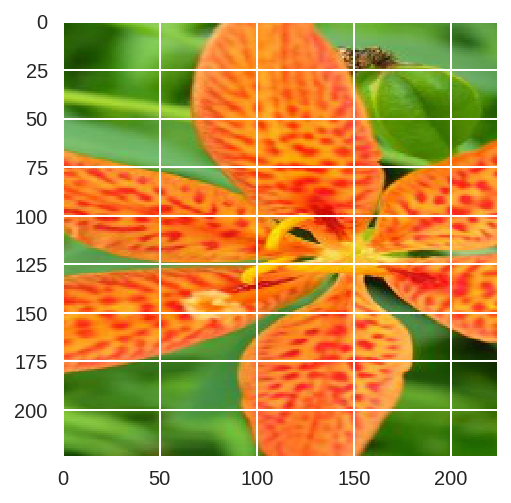

In [0]:
  image_path = 'test/102/image_08004.jpg'
  image = process_image(image_path)
  imshow(image)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, top_k=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    Implement the code to predict the class from an image file
    '''
    image = process_image(image_path)
    
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    
    image_t = image_tensor.unsqueeze_(0)
    
    # get the predictions
    preds = model.forward(image_t)
    
    # calculate its probabilities by applying softmax
    probs = F.softmax(preds, dim=1)
    
    # get top 5 along the column
    top_probs, top_labels = probs.topk(top_k, dim=1)
    
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labels = top_labels.detach().numpy().tolist()[0]
    
    # convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    # get top 5 labels as a list
    top_labels_list = [idx_to_class[label] for label in top_labels]
    
    # get top 5 flower names as a list
    top_flowers_list = [flower_label_list[ idx_to_class[label] ] for label in top_labels]
    
    return top_probs, top_labels, top_flowers_list

In [0]:
probs, classes, _ = predict(image_path, trained_model.to('cpu'))
print('Probs: ',probs)
print('Classes',classes)

Probs:  [0.9975669384002686, 0.0007166675059124827, 0.0005033214692957699, 0.0003821742138825357, 0.0003239497891627252]
Classes [4, 43, 41, 12, 72]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def sanity_check(image_path, model):
  '''
  Function to display an image along with the top 5 classes
  '''  
  #set up plot
  fig = plt.figure(figsize = (6,10))
  ax = plt.subplot(2, 1, 1)
  
  flower_num = image_path.split('/')[1]
  title_ = flower_label_list[flower_num]
  
  image = process_image(image_path)
  imshow(image, ax, title = title_)
  
  probs, labels, flower_names = predict(image_path, model)
  
  plt.subplot(2, 1, 2)
  sns.barplot(x = probs, y = flower_names, color=sns.color_palette()[0])
  plt.show()
  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


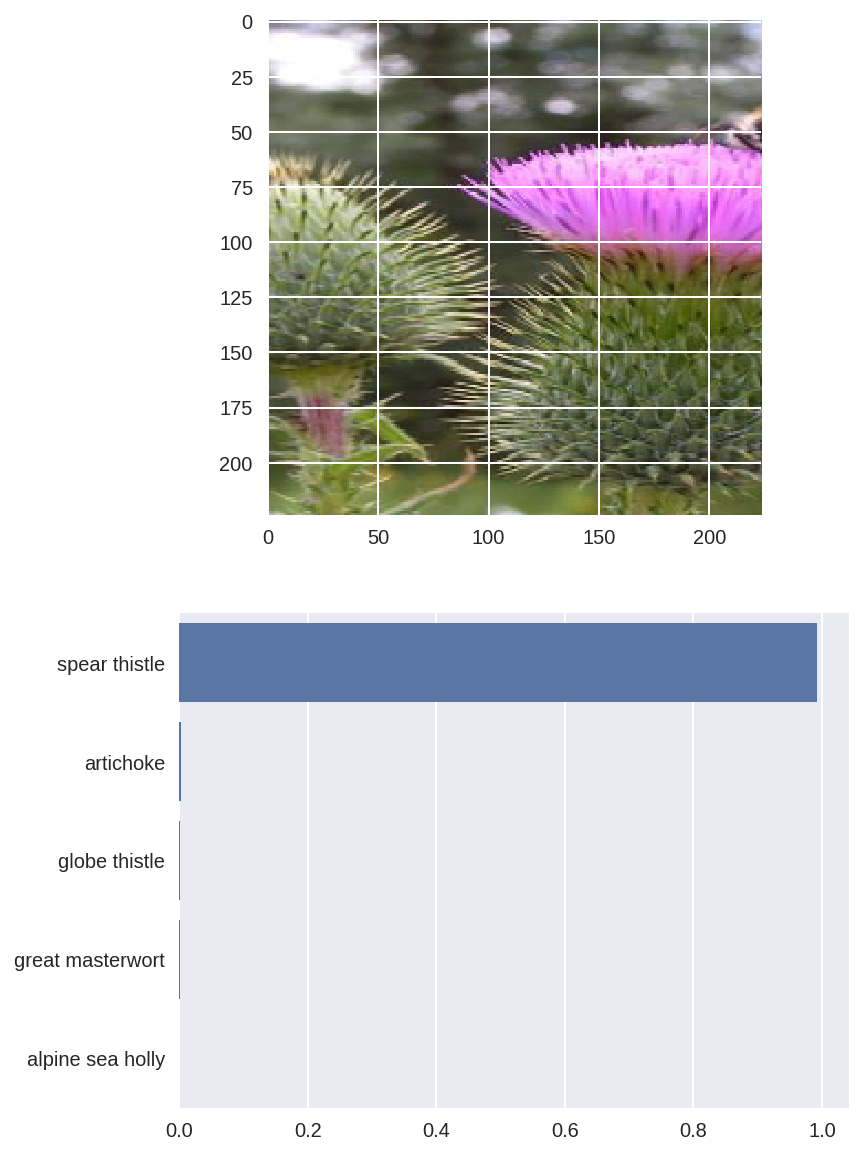

In [0]:
image_path = 'test/14/image_06052.jpg'
sanity_check(image_path, trained_model.to('cpu'))